This lab is adapted from the IBM Quantum Learning module “Quantum Coins — a module on superposition and interference” on the IBM Quantum platform
(see https://quantum.cloud.ibm.com/learning/en/modules/quantum-mechanics/superposition-with-qiskit).

Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from qiskit import QuantumCircuit
from IPython.display import Image
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import (
    SamplerV2 as Sampler,
    EstimatorV2 as Estimator,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from matplotlib.ticker import MaxNLocator
from collections import OrderedDict
from qiskit.quantum_info import Pauli
from math import pi
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector

## Introduction

This lab uses a coin to compare classical probability with quantum superposition. A classical coin flip is modeled as a random process with a 50–50 distribution of outcomes. The 'quantum coin' is a single qubit prepared by the Hadamard gate, where the same 50–50 statistics arise from the coherent state $\left(|0\rangle+|1\rangle\right)/\sqrt{2}$ rather than simple randomness. Using Qiskit on real hardware, classical and quantum coins are compared, expectation values along different axes are measured, and the role of phase in producing interference is studied. By visualizing states on the Bloch sphere and applying gates such as $H$, $X$, $\sqrt{X}$ and phase rotations, qubit states are understood as three dimensional rotations instead of classical mixtures, showing why measurement outcomes depend on the chosen basis.

#### Classical coin

As a point of comparison, the lab starts with a simulation of a classical coin flip, an example of a classical probabilistic state, where the outcome is essentially random, or the state of the coin before it lands is: $S(\text{coin})=\frac{1}{2}\left(|\text{up}\rangle+|\text{down}\rangle\right)$

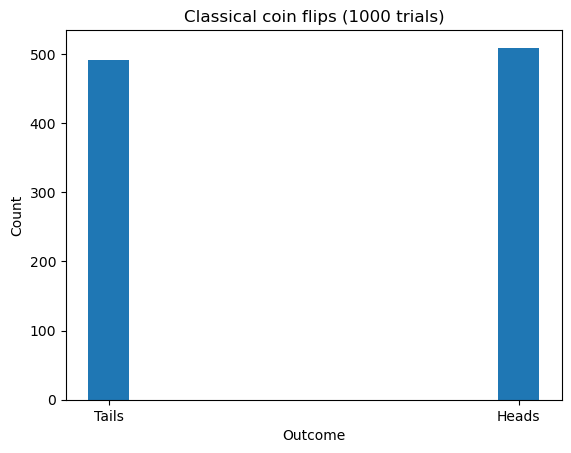

In [4]:
nflips = 1000 # number of flips
fliplist = [random.randint(0, 1) for _ in range(nflips)] 
# a list of each of the flips, with each outcome randomly generated 0 or 1

plt.hist(fliplist, bins=[-0.5, 0.5, 1.5], rwidth=0.1)
# histogram of fliplist, first bin -0.5 to 1 centered at 0, second bin 0.5 to 1.5 centered at 1
# setting the bins allows the bars to be centered at 0 and 1

plt.xticks([0, 1], ["Tails", "Heads"]) # 0 corresponds to tails, 1 corresponds to heads
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.title(f"Classical coin flips ({nflips} trials)")
plt.savefig("coin_flips.png", dpi=300) # saving plot if needed 
plt.show()

As expected, get ~ 50% heads and ~ 50% tails.

#### Quantum coin

The Hadamard gate creates quantum superposition and is defined as  

$$
H = \frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}.
$$

It acts on the computational basis states $(||0\rangle=(1,0)^T\text{ and }|1\rangle=(0,1)^T)$ as:  



$$
H|0\rangle 
= 
\frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}
\begin{bmatrix}
1 \\
0
\end{bmatrix}
=
\frac{1}{\sqrt{2}}
\begin{bmatrix}
1 \\
1
\end{bmatrix}
=
\frac{|0\rangle + |1\rangle}{\sqrt{2}},
$$

$$
H|1\rangle 
= 
\frac{1}{\sqrt{2}}
\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}
\begin{bmatrix}
0 \\
1
\end{bmatrix}
=
\frac{1}{\sqrt{2}}
\begin{bmatrix}
1 \\
-1
\end{bmatrix}
=
\frac{|0\rangle - |1\rangle}{\sqrt{2}},
$$

$$
\Rightarrow H|0\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}, \qquad
H|1\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}.
$$

$\therefore$ it transforms a definite state into an equal superposition of $|0\rangle\text{ and }|1\rangle$

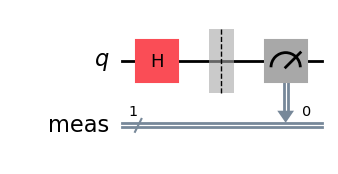

In [2]:
qcoin = QuantumCircuit(1) # create a quantum circuit with 1 qubit
#automatically initialized in state |0>

qcoin.h(0) # apply a Hadamard gate to qubit number 0
qcoin.measure_all() # Measure qubit 0 and store the result (0 or 1) in classical bit 0
 
qcoin.draw("mpl")

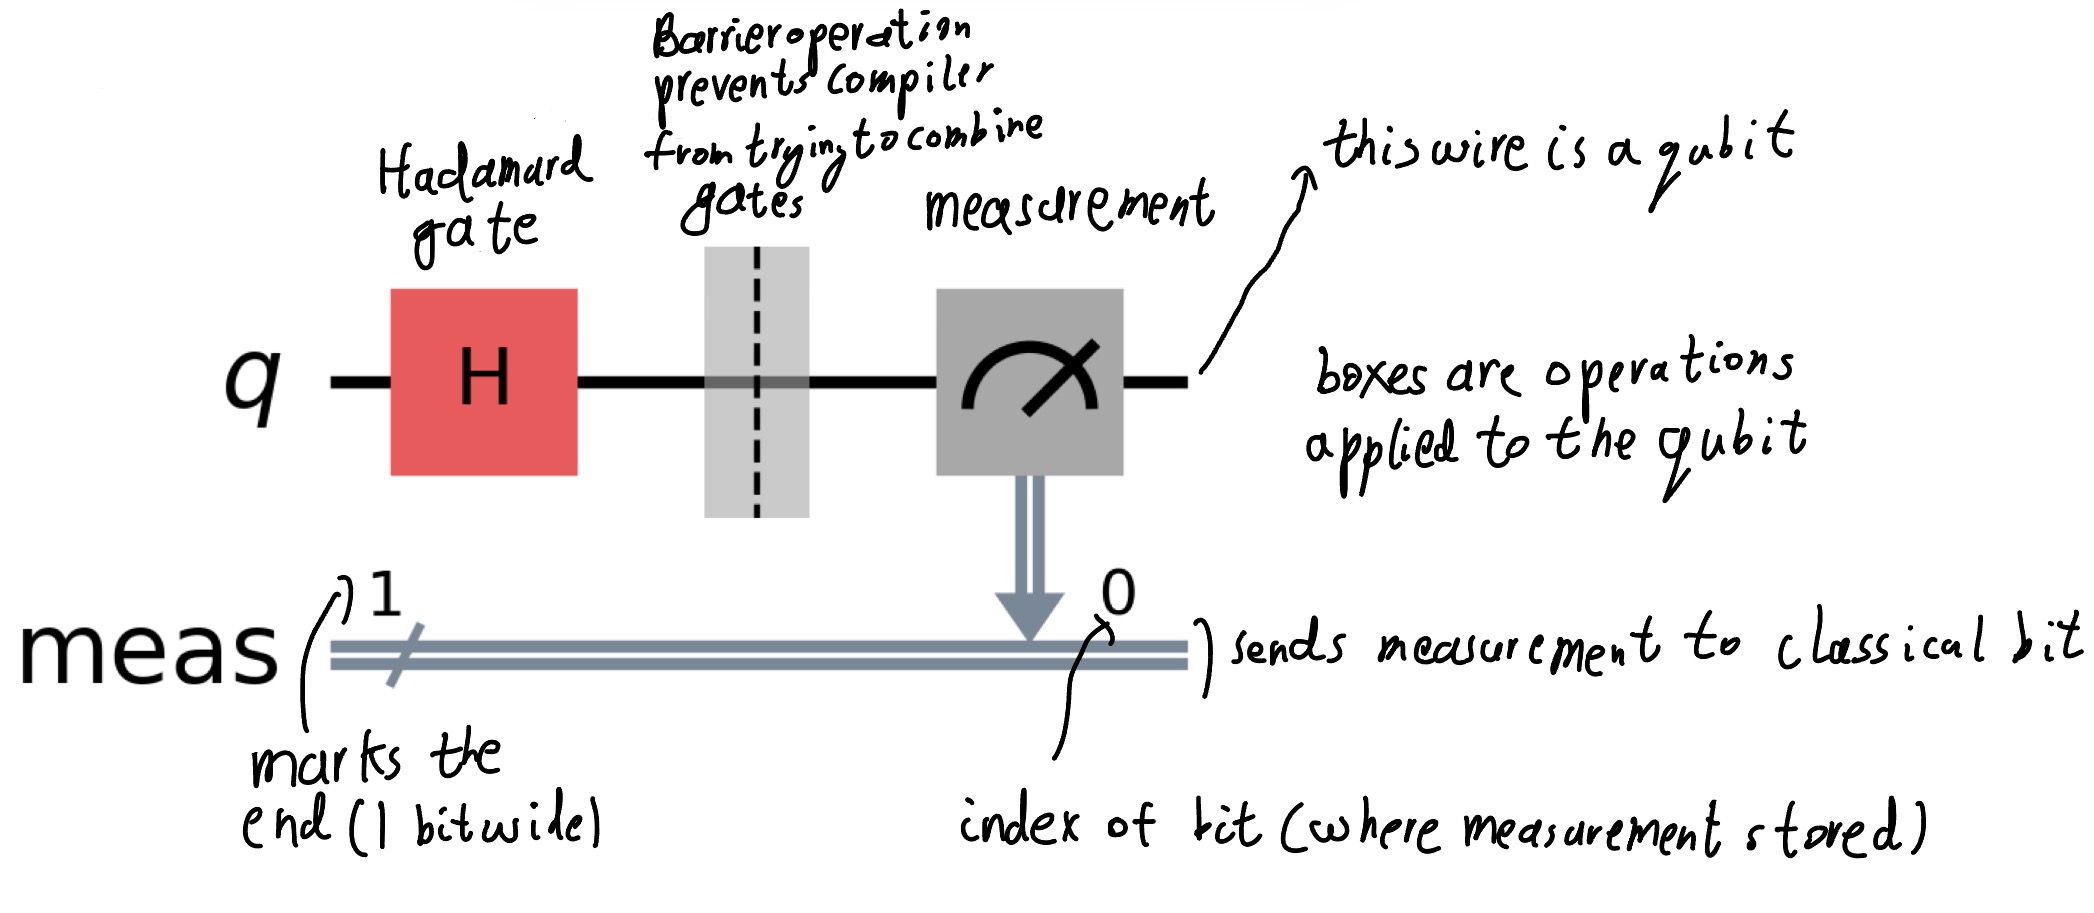

In [5]:
Image('qcoin_circuit.jpeg')

Optionally can save labelled fig

In [10]:
qcoin = QuantumCircuit(1)
qcoin.h(0)
qcoin.measure_all()

fig = qcoin.draw("mpl")
fig.axes[0].set_title("Quantum coin: Hadamard gate on |0⟩ then measure")
fig.savefig("qcoin_circuit.png", dpi=300)  

#### Quantum Backend

The 'quantum coin' is then run using real quantum hardware

In [5]:
service = QiskitRuntimeService(name="oxford")

management.get:WARNING:2025-10-14 11:09:51,787: Loading saved account: oxford


In [6]:
# Use the least busy backend
backend = service.least_busy()
# A backend is the quantum computer or simulator that actually runs your circuit

print(backend.name)

ibm_torino


In [7]:
## Transpile
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
qc_isa = pm.run(qcoin)

Transpilation converts the quantum circuit into a version that can run on the specific backend.

Optimization levels 0 = none, 3 = maximal, amount that the circuit is optimized (gates changed to run either more efficient, or/and using less gates).


The next step takes this circuit optimized for the specific backend, and repeats the circuits (1000 times), to sample the statistics of the resulting state, or 'flips the quantum coin 1000 times'.

In [35]:
## Execute
# On real hardware:
sampler = Sampler(mode=backend) 
pubs = [qc_isa] # Primitive Unified Blocs, holds circuit
job = sampler.run(pubs, shots=1000) # repeats the circuit 1000 times
res = job.result()
 
counts = res[0].data.meas.get_counts()
 

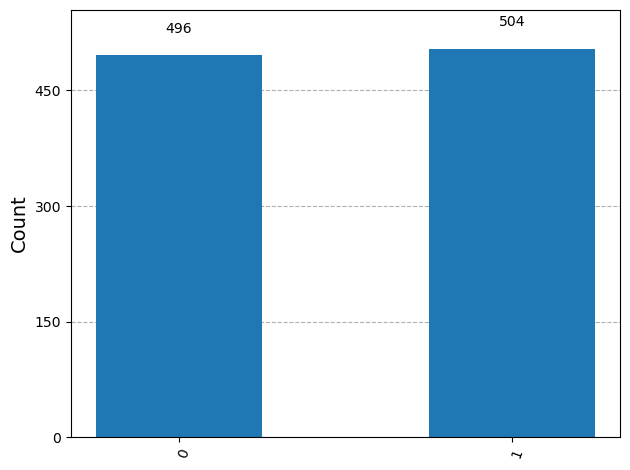

In [39]:
## Analysis

plot_histogram(counts)
#plt.hist(counts)

The histogram looks basically identical to the classical 'coin' histogram

**Expectation Value**

It is also possible to calculate the expectation value of an observable of the state. 
Consider the same state:  

$$
|\psi\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right),
$$

In the section before, measurements of the states were made in the Z-axis which is Qiskit's convention, therefore for a like comparison, consider the expectation value of the Pauli-$Z$ operator (with off-diagonal terms set to 0 by orthogonality):

$$
\langle \psi | Z | \psi \rangle 
= \frac{1}{2}\langle 0 | Z | 0 \rangle 
+ \frac{1}{2}\langle 1 | Z | 1 \rangle.
$$

With
$$
Z =
\begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix},
$$
we have $Z|0\rangle = +|0\rangle, \text{ and } Z|1\rangle = -|1\rangle\text{ } \Rightarrow \langle 0|Z|0\rangle = +1, \text{ and } \langle 1|Z|1\rangle = -1.$


$$
\therefore \langle \psi | Z | \psi \rangle
= \frac{1}{2}(+1) + \frac{1}{2}(-1) = 0.
$$

$\Rightarrow$ the expectation value of the $Z$ measurement is zero, meaning there is an equal probability of obtaining $+1$ (for $|0\rangle$) or $-1$ (for $|1\rangle$).

Evaluating the expectation value of $Z$ for the same state below using Estimator on quantum hardware should give the same result.

In [45]:
qcoin = QuantumCircuit(1)
qcoin.h(0)
 
# for Estimator, we do not apply the measurement to the circuit

In [46]:
## Transpile
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
obs = Pauli("Z")
 
qc_isa = pm.run(qcoin)
obs_isa = obs.apply_layout(layout=qc_isa.layout)

In [47]:
## Execute
 
# On real hardware:
estimator = Estimator(mode=backend)
pubs = [(qc_isa, obs_isa)]
#Prepare the state with the circuit, then evaluate the observable’s expectation value on that state
job = estimator.run([[qc_isa, obs_isa]])
res = job.result()
 
 
print(res[0].data.evs)

0.008446614755180151


The expectation value is ~0 as expected (variations mainly due to hardware noise).

## The quantum revealed: an experiment in three dimensions

This section looks at how far the comparison between a 'coin flip' and a 'quantum coin flip' goes.

Changing axis in the classical coin flip, the outcomes will remain 50-50, the question is, does this hold for a quantum coin? 

This is tested by calculating the expectation value of $X$ for this state. i.e. do outcomes of $|+\rangle \text{ and }|-\rangle$ have equal probability?

In [48]:
# Step 1: map problem
 
qcoin_lr = QuantumCircuit(1)
qcoin_lr.h(0)
 
obs = Pauli("X")
 
 
# Step 2: Transpile the circuit
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qcoin_lr)
obs_isa = obs.apply_layout(layout=qc_isa.layout)
 
# Step 3: Run the circuit on a real quantum computer
 
estimator = Estimator(mode=backend)
pubs = [(qc_isa, obs_isa)]
job = estimator.run([[qc_isa, obs_isa]])
res = job.result()
 

# Step 4: Return the result in classical form, and analyze.
 
print(res[0].data.evs)

0.9766043654424258


The expectation value is 1, which means there is 100% probability (up to hardware noise) of measuring $|+\rangle$

When comparing to what is expected classically, this is surprising, but with prior knowledge in quantum mechanics that $|+\rangle=\frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle\right)$, this is not surprising.

#### Quantum Phase

This outcome the highlights between classical and quantum states, the classical state $S(\text{coin})=c_1|\text{up}\rangle+c_2|\text{down}\rangle$ has real, positive coefficients that represents the probability of measuring that particular state.

In a quantum state, the coefficients $c_1\text{ and }c_2$ are complex, and can be expressed as $c_i = |c_i| e^{i\phi_i}$, with phase $\phi_i$. This phase is uniquely quantum, and can lead to constructive or destructive interference.

To see the phase, try applying the Hadamard (flip) twice

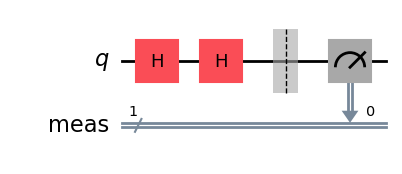

In [49]:
qcoin_0 = QuantumCircuit(1)
qcoin_0.h(0)
qcoin_0.h(0)
qcoin_0.measure_all()
 
qcoin_0.draw("mpl")

In [50]:
qcoin_0 = QuantumCircuit(1)
qcoin_0.h(0)
qcoin_0.h(0)
qcoin_0.measure_all()

fig = qcoin_0.draw("mpl")
fig.axes[0].set_title("Quantum coin: Hadamard gate applied twice on |0⟩ then measure")
fig.savefig("qcoin_0_circuit.png")  
plt.show()

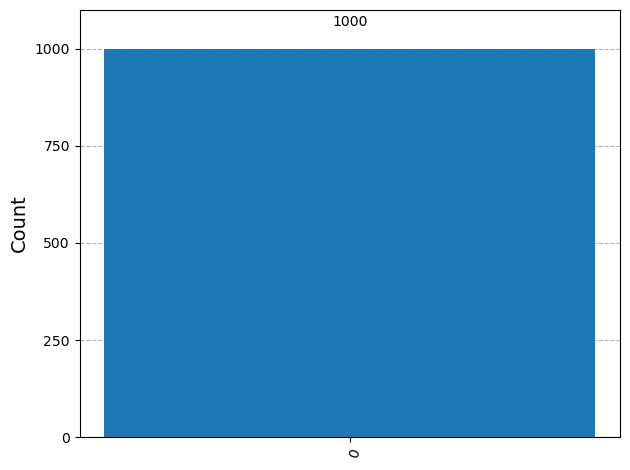

In [51]:
## Transpile
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
qc_isa = pm.run(qcoin_0)
 
## Execute
 
# On real hardware:
sampler = Sampler(mode=backend)
pubs = [qc_isa]
job = sampler.run(pubs, shots=1000)
res = job.result()
 
counts = res[0].data.meas.get_counts()
 
 
## Analyze
plot_histogram(counts)

The second Hadamard has canceled out the first, and we’ve returned to the $|0\rangle$ (initial) state.

Hadamard applied to $|0\rangle\text{ and } |1\rangle$ respectively was calculated earlier as:

$$
H|0\rangle= \frac{|0\rangle + |1\rangle}{\sqrt{2}},\text{ }H|1\rangle =\frac{|0\rangle - |1\rangle}{\sqrt{2}},(c_2\text{ has phase }\phi=\pi)
$$


$\Rightarrow$ the $|0\rangle$ terms interfere constructively, but the $|1\rangle$ terms interfere destructively and cancel each other out.

Another way to see this is that,
$$
H^2 = \frac{1}{2}
\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}
\begin{bmatrix}
1 & 1 \\
1 & -1
\end{bmatrix}=I.
$$


#### Phase gate

Exploring the idea of phase further, apply Hadamard, then phase shift of $\pi$ radians, then Hadamard, and measure. 

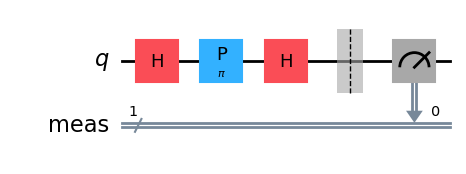

In [14]:
qcoin_pi = QuantumCircuit(1)
qcoin_pi.h(0)
qcoin_pi.p(np.pi, 0) #second argument is target qubit index
# phase applied about Z axis
qcoin_pi.h(0)
qcoin_pi.measure_all()
 
qcoin_pi.draw("mpl")

In [58]:
qcoin_pi = QuantumCircuit(1)
qcoin_pi.h(0)
qcoin_pi.p(np.pi, 0)
qcoin_pi.h(0)
qcoin_pi.measure_all()

fig = qcoin_pi.draw("mpl")
fig.axes[0].set_title("Quantum coin: Hadamard gate applied, phase shift of $\pi$, then second Hadamard on |0⟩ then measure")
fig.savefig("qcoin_pi_circuit.png")  
plt.show()

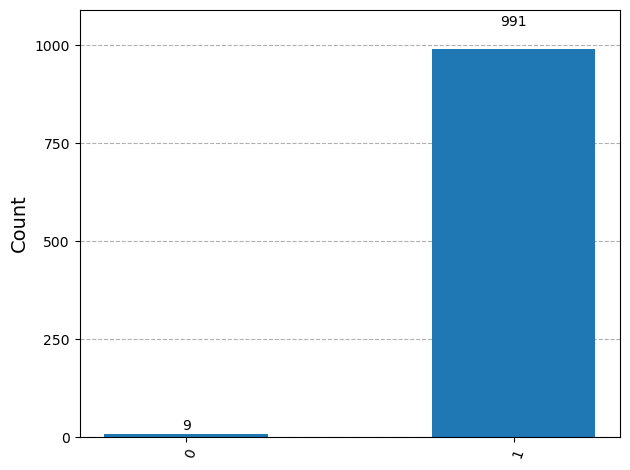

In [56]:
## Transpile
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
qc_isa = pm.run(qcoin_pi)
 
## Execute
 
# On real hardware:
sampler = Sampler(mode=backend)
pubs = [qc_isa]
job = sampler.run(pubs, shots=1000)
res = job.result()
 
counts = res[0].data.meas.get_counts()
 

 
## Analyze
plot_histogram(counts)

The phase shift changes the measured state from $|0\rangle$ as seen earlier, to $|1\rangle$. This makes sense as (from earlier),

$$
H|0\rangle= \frac{|0\rangle + |1\rangle}{\sqrt{2}},\text{ }H|1\rangle =\frac{|0\rangle - |1\rangle}{\sqrt{2}},
$$

and applying $\pi$ phase gives,
$$
R_Z(\pi)H|0\rangle= \frac{|0\rangle - |1\rangle}{\sqrt{2}},\text{ }R_Z(\pi)H|1\rangle =\frac{|0\rangle + |1\rangle}{\sqrt{2}}
$$
(where $R_Z(\pi)H$ applies $H$ then $R$  )

#### Try yourself

Question: Edit the code cell below to change the phase such that the second Hadamard creates a superposition state with probabilities of 25% and 75% of finding the state in $|0\rangle\text{ and } |1\rangle$ respectively. Verify your answer with math.

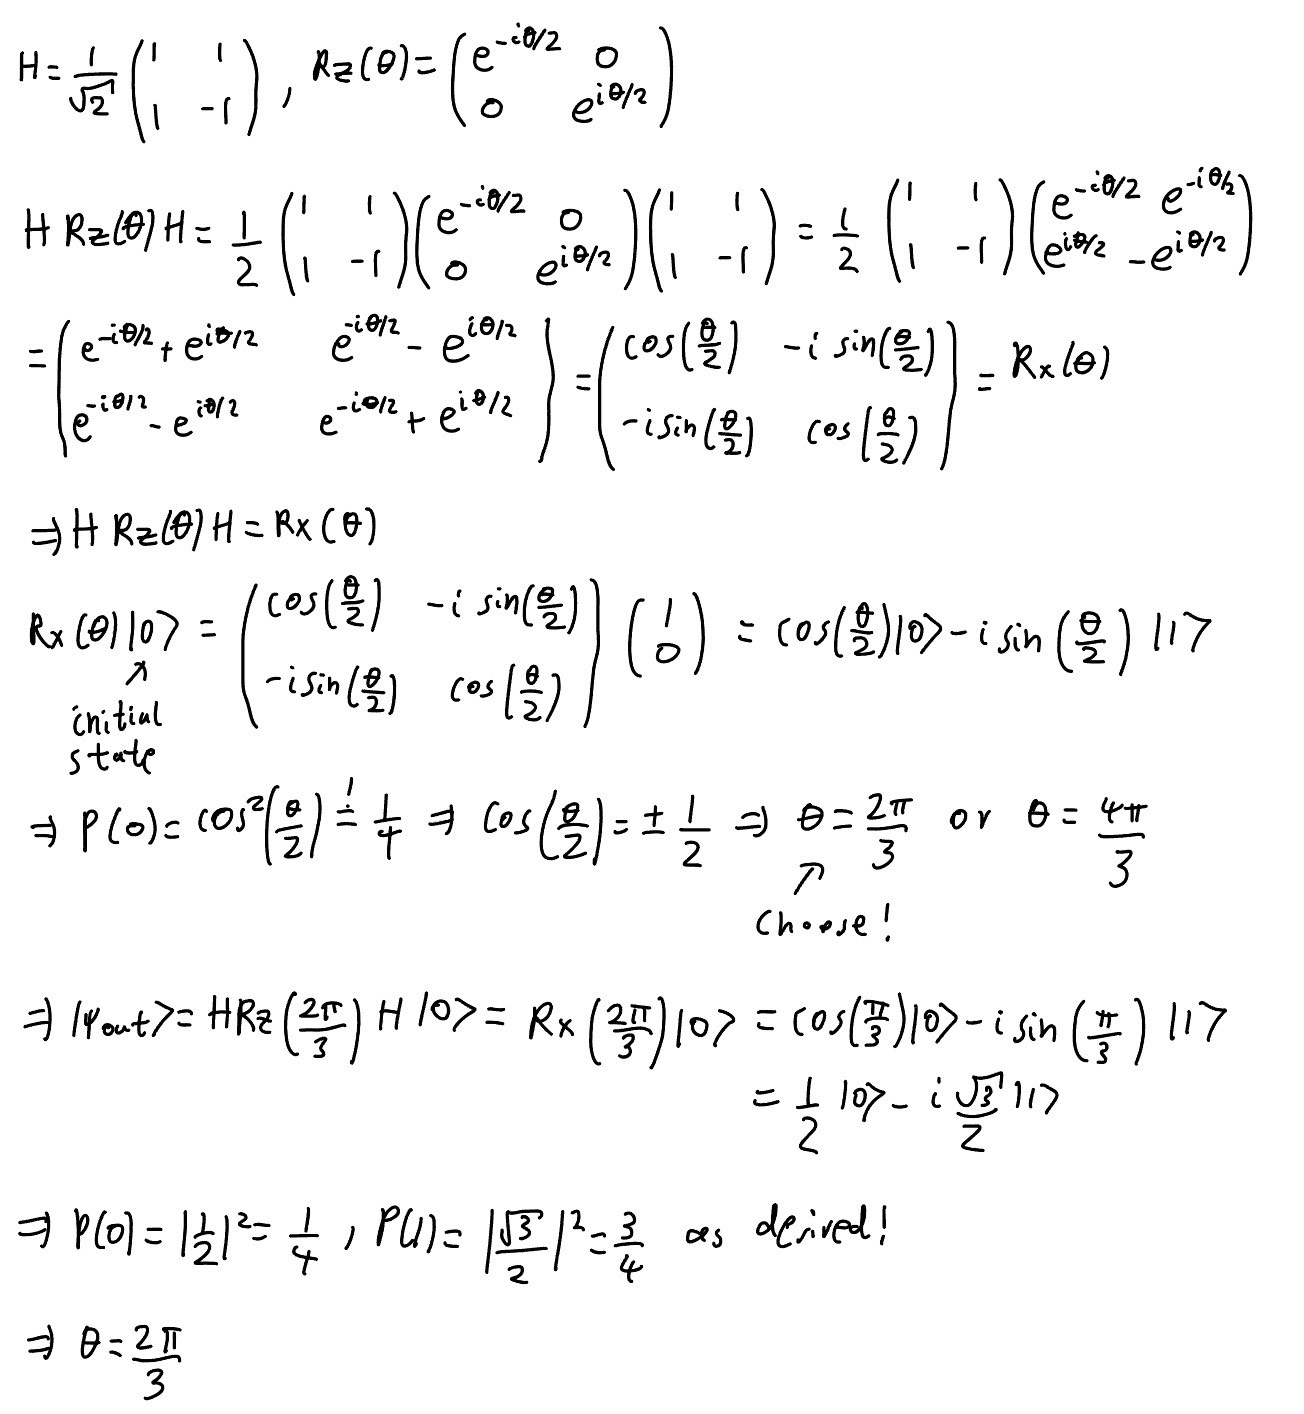

In [18]:
Image('Phase_calculation.jpeg',width=1000)

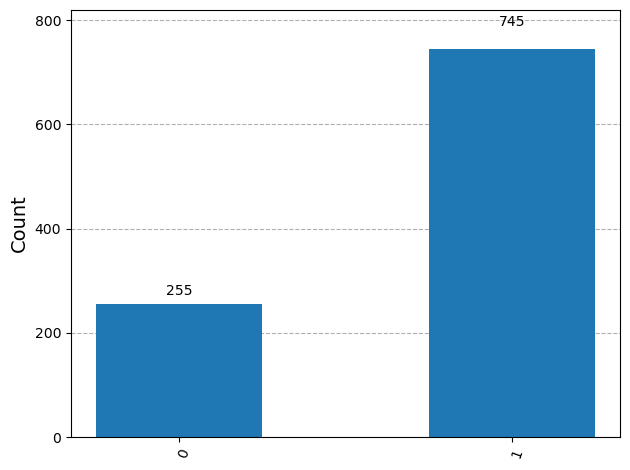

In [61]:
qcoin_phase = QuantumCircuit(1)
qcoin_phase.h(0)
# replace "x" below with a phase from 0 to 2*np.pi (this cell won't run if you leave x)
qcoin_phase.rz(2*np.pi/3, 0)
qcoin_phase.h(0)
qcoin_phase.measure_all()
 
 
## Transpile
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
 
qc_isa = pm.run(qcoin_phase)
 
## Execute
 
# On real hardware:
sampler = Sampler(mode=backend)
pubs = [qc_isa]
job = sampler.run(pubs, shots=1000)
res = job.result()
 
counts = res[0].data.meas.get_counts()
 
 
# or with Aer simulator with noise model from real backend
# job = sampler_sim.run([qc_isa])
# counts=job.result()[0].data.meas.get_counts()
 
## Analyze
plot_histogram(counts)

Find $|0\rangle$ with probability ~25% and $|1\rangle$ with probability ~75% as desired!

#### Using the $\sqrt{\text{NOT}}$ gate

Clearly flipping a coin is different from creating a superposition state, the next part exploares a better analogy made to a coin to capture the superposition phenomena.

Consider the Pauli-X gate: 

$$
X =
\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}.
$$

Applied to the computational basis states :  

$$
X|0\rangle
=
\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}
\begin{bmatrix}
1 \\
0
\end{bmatrix}
=
\begin{bmatrix}
0 \\
1
\end{bmatrix}
=
|1\rangle,
$$

$$
X|1\rangle
=
\begin{bmatrix}
0 & 1 \\
1 & 0
\end{bmatrix}
\begin{bmatrix}
0 \\
1
\end{bmatrix}
=
\begin{bmatrix}
1 \\
0
\end{bmatrix}
=
|0\rangle.
$$

$\therefore$ it flips the qubit state, exchanging $|0\rangle$ and $|1\rangle$, or rotates the states 180 degrees around the x-axis.

Applied to the computational basis, this is like a NOT gate.  

More formally, imagine the coin can rotate freely about the $x$, $y$, and $z$ axes, and the coin’s head is the direction of the coin’s vector. Using the notation of Qiskit, where  
$|0\rangle$ is the $+z$ axis,  
$|1\rangle$ the $-z$ axis,  
$|+\rangle$ the $+x$ axis,  
$|-\rangle$ the $-x$ axis,  
$|+i\rangle$ the $+y$ axis $\left(|{+}i\rangle=\frac{|0\rangle+i|1\rangle}{\sqrt{2}}\right)$, and  
$|-i\rangle$ the $-y$ axis.  

Starting in the $|0\rangle$ state can be seen as the coin lying flat on a table, with the head pointing up. Applying an $X$ gate rotates the coin 180 degrees about the $x$ axis, flipping the coin, so now the coin is in the $|1\rangle$ state.  

Consider again starting in the $|0\rangle$ state, and now applying a $\sqrt{X}$ gate. This rotates the coin about the $x$ axis by 90 degrees. The head now points in the $-y$ direction, which means a measurement in the $y$ basis is always the $-y$ outcome deterministically. A measurement in the $z$ basis gives heads or tails with equal probability, and likewise in the $x$ basis.  

This explains that applying the Hadamard gate to the state $|0\rangle$ creates a superposition $\frac{|0\rangle + |1\rangle}{\sqrt{2}},$ which, when measured in the $z$ basis, gives a 50–50 outcome. In the $\{|+\rangle, |-\rangle\}$ basis, the state is exactly $|+\rangle$, so a measurement in that basis yields $|+\rangle$ with certainty.  

This suggests that a coin sitting still on its edge can be a better way to visualize a superposition state of a qubit than a coin flipping through the air. The rotations described can be seen as rotations around the bloch sphere!

To verify this, apply the $\sqrt{X}$ gate, and find the expectation values of the $X$, $Y$ and $Z$ observables.

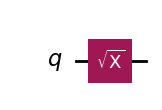

In [62]:
qcoin_sx = QuantumCircuit(1)
qcoin_sx.sx(0)
 
qcoin_sx.draw("mpl")

In [64]:
fig = qcoin_sx.draw("mpl")
fig.axes[0].set_title("$\sqrt{NOT}$ gate on |0⟩")
fig.savefig("qcoin_sx_circuit.png")  
plt.show()

In [65]:
obs1 = Pauli("X")
obs2 = Pauli("Y")
obs3 = Pauli("Z")
 
 
# Step 2: Transpile the circuit
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_isa = pm.run(qcoin_sx)
obs1_isa = obs1.apply_layout(layout=qc_isa.layout)
obs2_isa = obs2.apply_layout(layout=qc_isa.layout)
obs3_isa = obs3.apply_layout(layout=qc_isa.layout)
 
 
# Step 3: Run the circuit on a real quantum computer
 
estimator = Estimator(mode=backend)
pubs = [(qc_isa, [[obs1_isa], [obs2_isa], [obs3_isa]])]
job = estimator.run(pubs)
res = job.result()
 

# Step 4: Return the result in classical form, and analyze.
 
print(res[0].data.evs)

[[ 0.03563593]
 [-0.96802074]
 [-0.02021142]]


This means that when measured in the $z$ or $x$ basis, the result is probabilistic with a 50–50 chance, and in the $y$ basis the result is deterministic, you always get the -y outcome.

## The qubit state as a Bloch vector

Any single-qubit pure state can be shown by a Bloch vector on the unit sphere. With polar angle $,\theta,$ and azimuth $,\phi,$ the state is: 
$$
|\psi\rangle=\cos\frac{\theta}{2}|0\rangle+e^{i\phi}\sin\frac{\theta}{2}|1\rangle,
$$
where the Bloch vector has radius $r=1$.

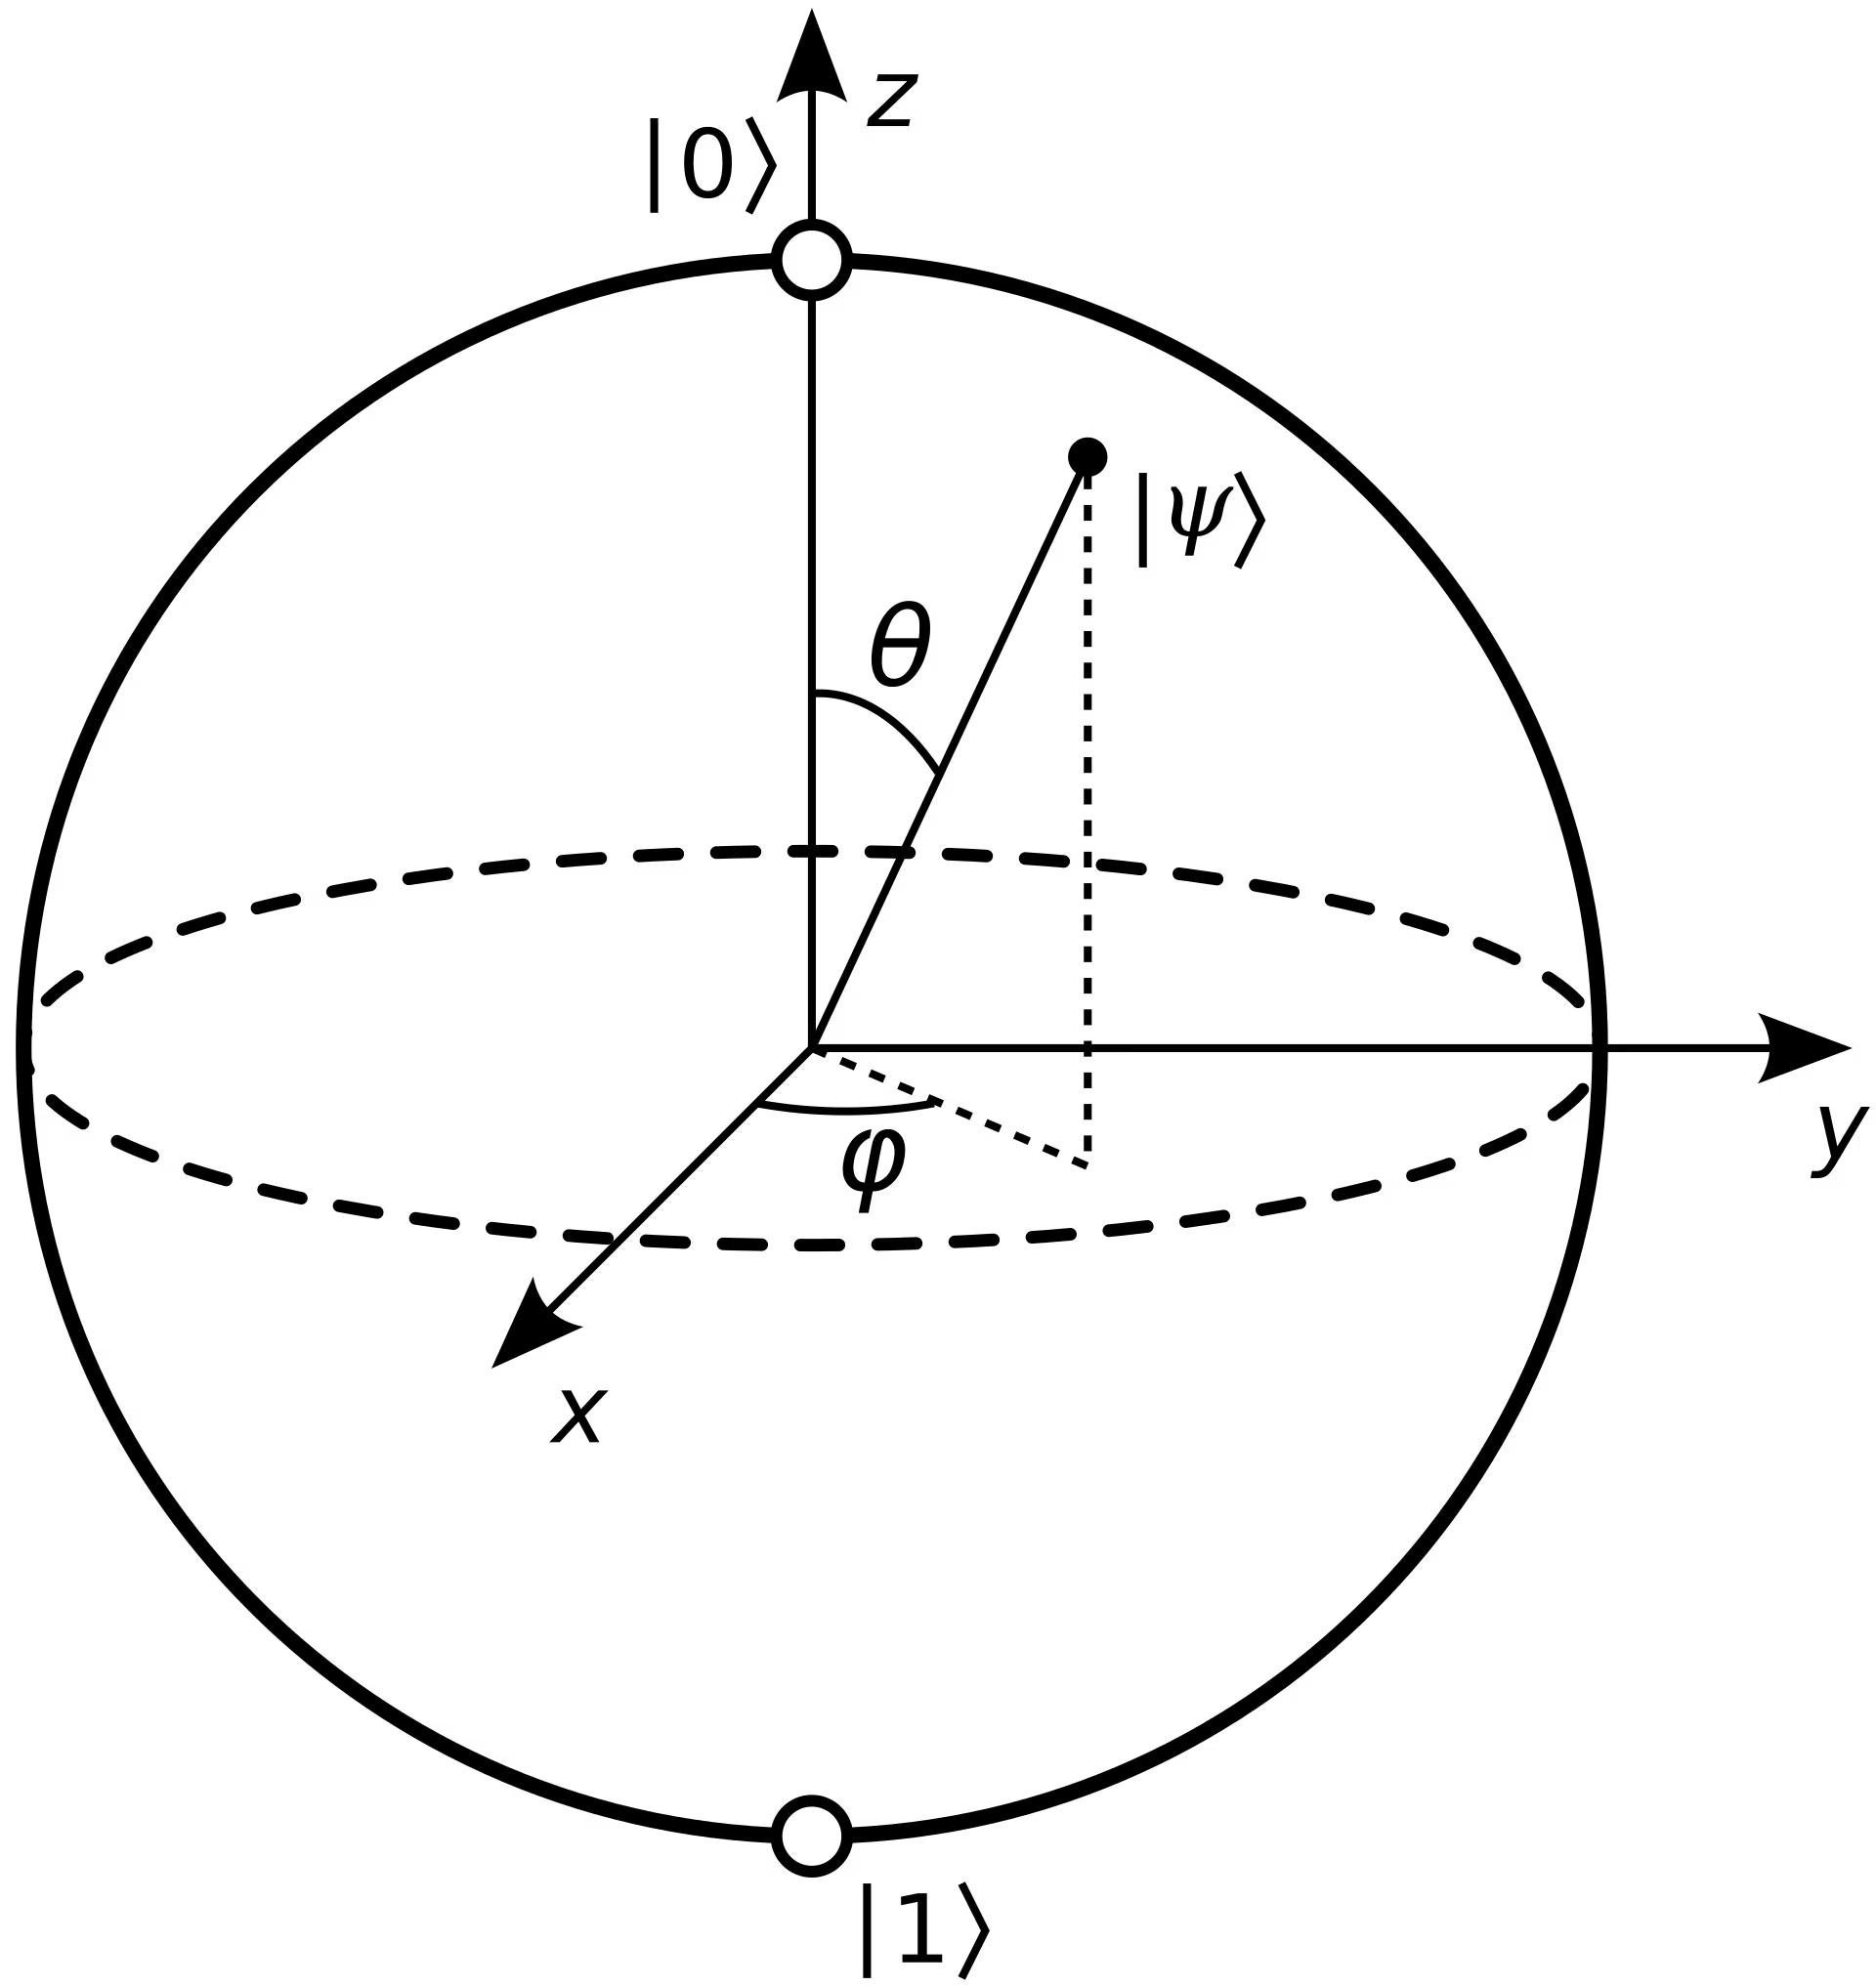

In [22]:
Image('bloch-sphere.png',width=600)

Below shows visually how the Bloch vector changes when various gates are applied to the $|0\rangle$ state.

**NOT**

NOT rotates the vector 180 degrees about the $x$-axis, so the state $|1\rangle$ is expected.

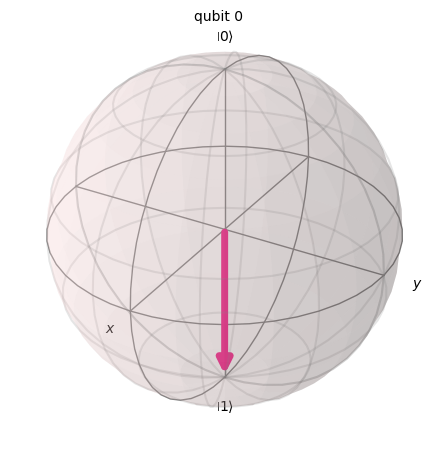

In [23]:
qnot = QuantumCircuit(1)
qnot.x(0)
 
plot_bloch_multivector(qnot)

$\mathbf{\sqrt{NOT}}$

$\sqrt{NOT}$ rotates the vector 90 degrees about the $x$-axis, using the right hand rule, the state $|-i\rangle$ is expected.

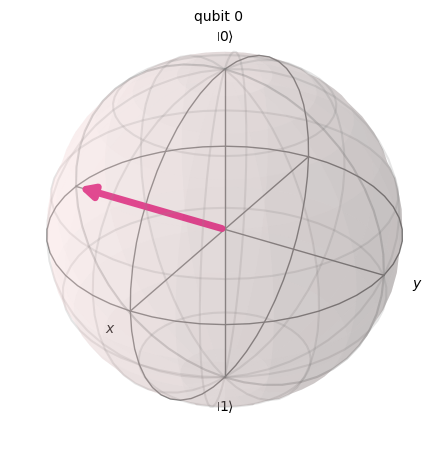

In [23]:
qsqrtnot = QuantumCircuit(1)
qsqrtnot.sx(0)
 
plot_bloch_multivector(qsqrtnot)

**PHASE** $\mathbf{\phi=\pi}$

PHASE $\phi=\pi$ rotates the vector 180 degrees about the $z$-axis, so the state $|0\rangle$ is expected $\left(\text{since }Z|0\rangle=|0\rangle\right)$. 

If the PHASE $\phi=\pi$ gate was applied to the state $|1\rangle$, it would rotate the vector 180 degrees about the $z$-axis, so the state $-|1\rangle$ is expected, which is the state $|1\rangle$ up to a global phase $\left(\text{since }Z|1\rangle=-|1\rangle\right)$.

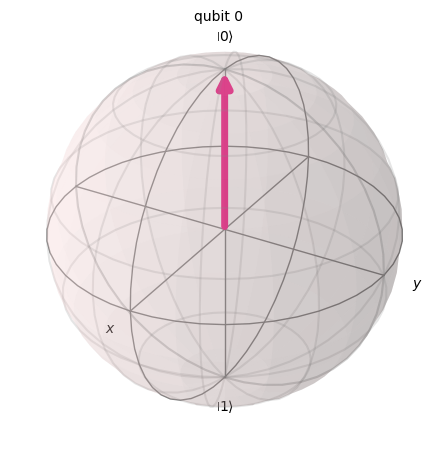

In [16]:
qphase = QuantumCircuit(1)
qphase.p(np.pi, 0)
 
plot_bloch_multivector(qphase)

$\mathbf{\sqrt{NOT}}$ **and then PHASE** $\mathbf{\phi=\pi}$

$\sqrt{NOT}$ rotates the vector 90 degrees about the $x$-axis, to the state $|-i\rangle$, PHASE $\phi=\pi$ rotates the vector 180 degrees about the $z$-axis, so the state $|+i\rangle$ is expected. 

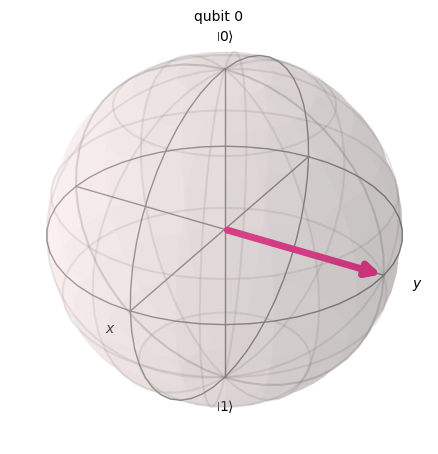

In [17]:
qsqrtnot.p(np.pi, 0)
plot_bloch_multivector(qsqrtnot)

**Hadamard**

The Hadamard gate rotates the vector 90 degrees around the $y$-axis $\left(\text{to intermediate state }|+\rangle\right)$, then 180 degrees around the $x$-axis, so the state $|+\rangle$ is expected $\left(\text{since }X|+\rangle=|+\rangle\right)$.

If the Hadamard gate was applied to the state $|1\rangle$, it would rotate the vector 90 degrees around the $y$-axis $\left(\text{to intermediate state }|-\rangle\right)$, then 180 degrees around the $x$-axis, so the state $-|-\rangle$ is expected, which is the state $|-\rangle$ up to a global phase $\left(\text{since }X|-\rangle=-|-\rangle\right)$.

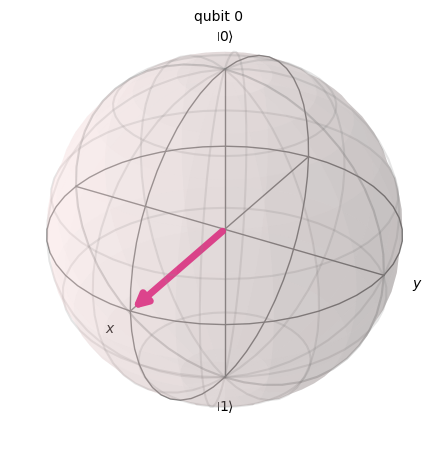

In [69]:
qhadamard = QuantumCircuit(1)
qhadamard.h(0)
 
plot_bloch_multivector(qhadamard)

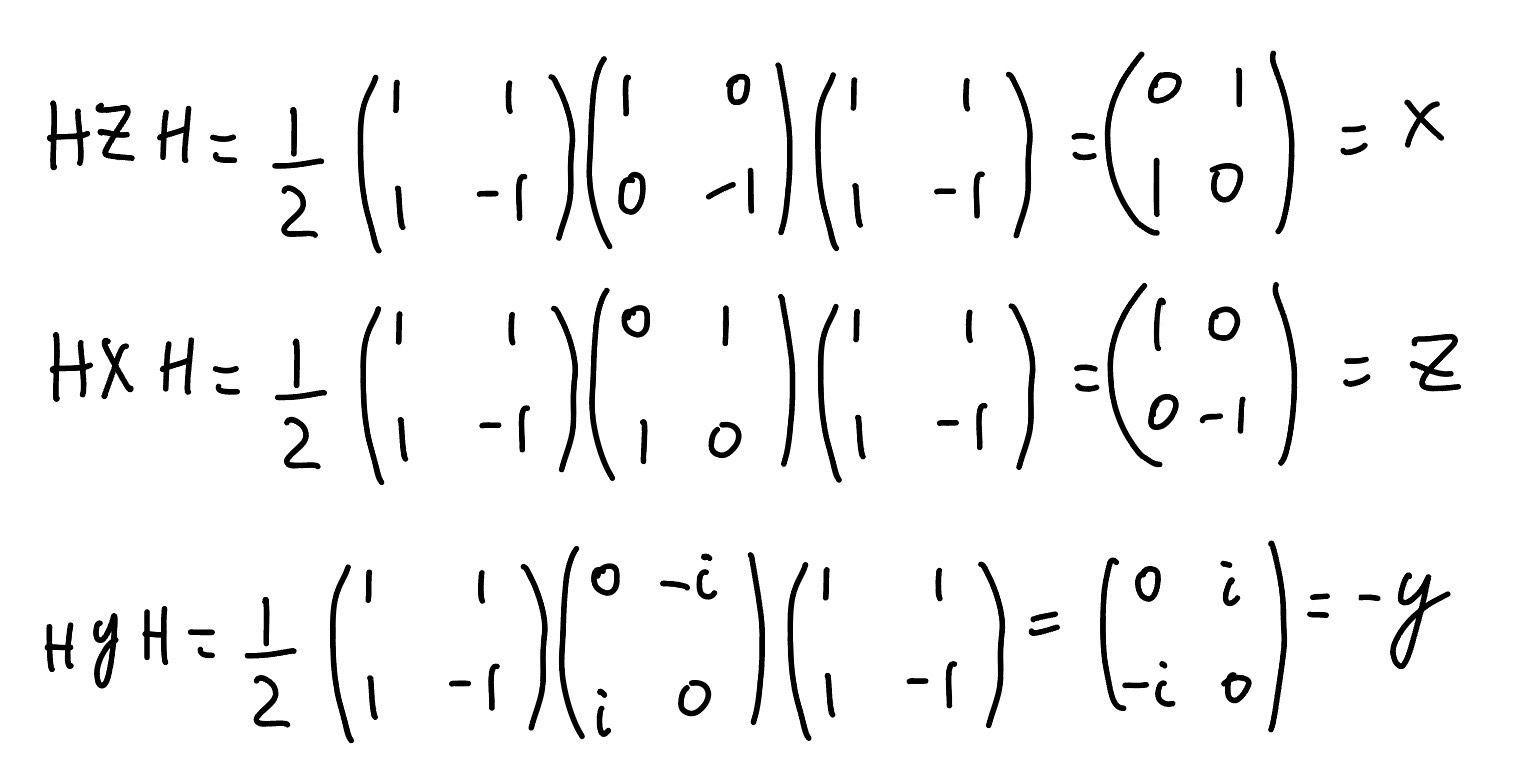

In [25]:
Image('HZH.jpeg',width=500)

Since $HZH=X$, and $HXH=Z$, the Hadamard gate effectively swaps $z$ and $x$ axes, which can be useful for Sampler if measurement in the $x$ axis is required. More explicitly, $\langle \psi|X|\psi\rangle = \langle \psi|H Z H|\psi\rangle = \langle \psi’|Z|\psi’\rangle,$ where $|\psi’\rangle = H|\psi\rangle.$

## Conclusion

The module opened with a coin flip analogy for measuring superposition, with the Hadamard gate likened to a flip. It was then shown that a qubit in superposition evolves deterministically as a Bloch vector, much like a coin fixed in three dimensions. Randomness arises only at measurement, when the state is projected onto the chosen axis.

Whether a state is a superposition depends on the measurement basis. A coordinate system can be chosen so the state points along one axis and is not a superposition there. The question must be asked of what the superposition is.

The Bloch sphere is only a visualization of measurement probabilities. What a quantum state is doing before measurement cannot be stated.

## Questions

**True/False Questions**

1. *A quantum superposition is basically the same as a probabilistic event in classical physics, like flipping a coin.*

**False**, a quantum superposition is not the same as a probabilistic event in classical physics. It represents a coherent combination of states, not a random mixture like a coin flip.

2. *The length of the Bloch vector describing the state of a single isolated qubit is always 1.*

**True**, the length of the Bloch vector describing a single, isolated (pure) qubit is always 1.

3. *Single-qubit quantum gates do not change the length of the Bloch vector.*
**True**, single-qubit quantum gates correspond to rotations on the Bloch sphere, so they do not change the length of the Bloch vector.

**Multiple Choice Questions**

1. *Select the correct Bloch vector that represents the state*

$$
|\Psi\rangle = \sqrt{\frac{1}{3}}\,|0\rangle + e^{i\pi/4}\sqrt{\frac{2}{3}}\,|1\rangle.
$$

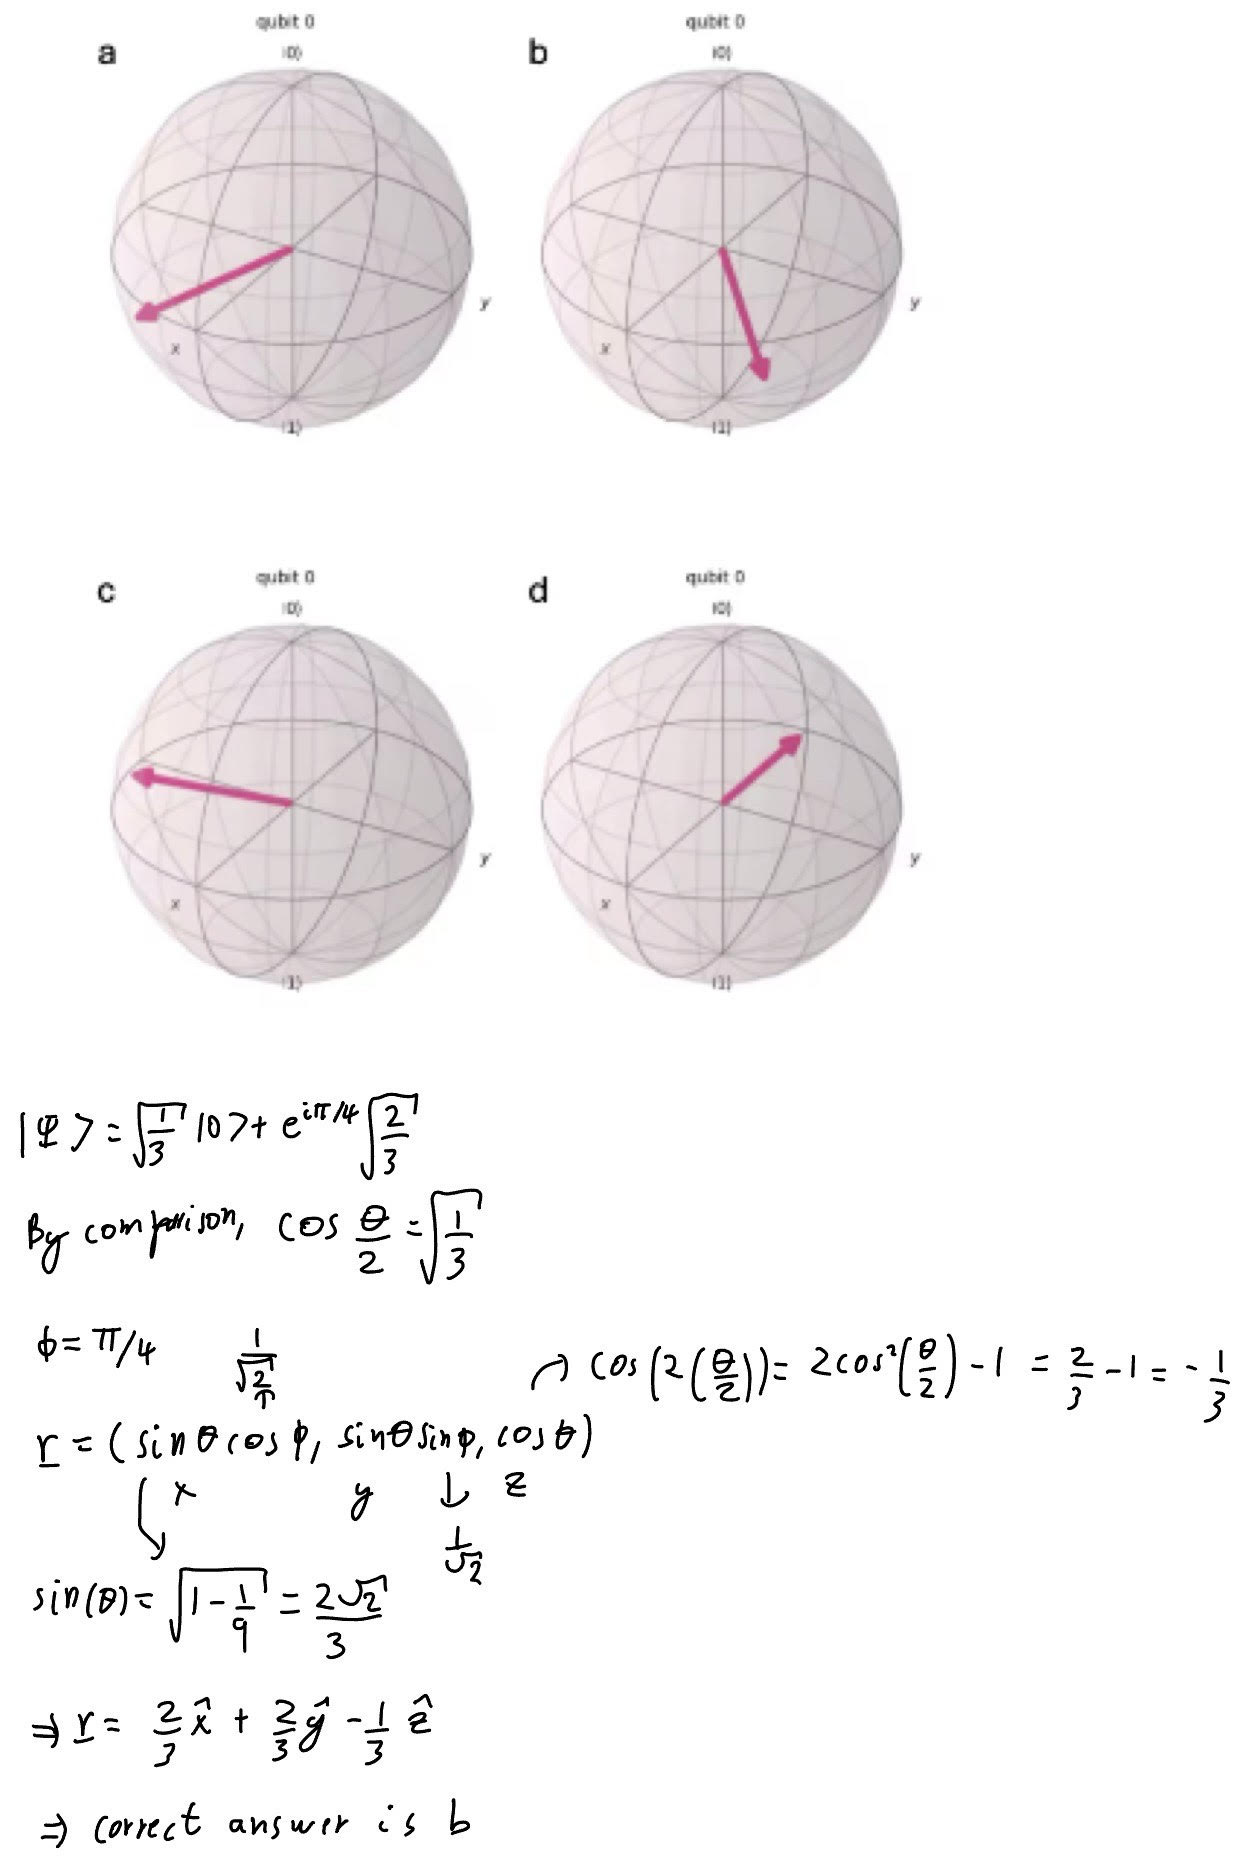

In [4]:
Image('MC_1.jpg',width=700)

2. *The Bloch sphere describes a qubit's: (select all that apply)*

*a. amplitude*  

*b. entanglement with other qubits*  

*c. phase* 

*d. color*  

*e. probability of measurement outcomes*  
 
**a, c, e.**


The Bloch sphere represents the state of a single qubit as a point on the unit sphere.

The direction of the Bloch vector encodes the relative amplitudes and phase between the states $|0\rangle$ and $|1\rangle$, and the squared amplitudes give the measurement probabilities in the chosen basis.


**Discussion Questions**

1. *Why can the state of a qubit be visualized on the Bloch sphere, but the probability distribution of a coin flip cannot?*

The key difference is **coherence**.

A qubit can exist in a superposition of its basis states $|0\rangle$ and $|1\rangle$, meaning it has well-defined amplitude and phase information. As seen earlier this introduces interference effects, so a qubit’s full state requires both magnitude and direction, which can be represented as a point on the Bloch sphere.

A classical coin flip only has a probability distribution. There is no phase relationship or coherent combination of outcomes, only a statistical mixture. So it is not represented by a unique point on the Bloch sphere surface.

2. *Why is a coin flipping in the air not the best analogy to a quantum superposition state? What aspect of superpositions are not captured in this analogy?*


A coin flipping in the air is not the best analogy to a quantum superposition because the coin is always in one definite classical state. At any given instant, it is either heads or tails (even if we do not yet know which). Its uncertainty is purely statistical, reflecting our lack of knowledge about the system.

A quantum superposition, on the other hand, represents a state that is physically both $|0\rangle$ and $|1\rangle$ at once, with well defined complex amplitudes that include phase information.  

**Challenge problems**


1. *Use Qiskit to create a circuit that transforms the state $|0\rangle$ to the state $\frac{\sqrt{3}}{2}\,|0\rangle + \frac{1}{2}e^{i5\pi/6}\,|1\rangle.$*

$2\cos^{-1}\!\left(\frac{\sqrt{3}}{2}\right) = \frac{\pi}{3}$

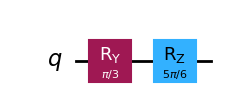

In [9]:
qc = QuantumCircuit(1)

# Amplitudes
qc.ry(pi/3, 0)

# Set the relative phase on |1> to e^{i * 5pi/6}.
qc.rz(5*pi/6, 0)

qc.draw("mpl")

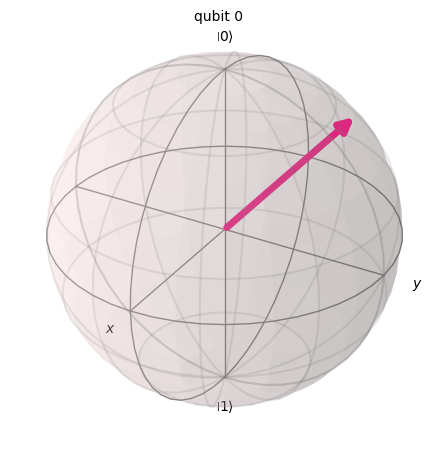

In [10]:
plot_bloch_multivector(qc)